# Machine Learning in Python - Project 1

Due Friday, March 11th by 5 pm.

*include contributors names here*

## 0. Setup

In [1]:
# Add any additional libraries or submodules below

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
#import sklearn
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# The regression tree
from sklearn.tree import DecisionTreeRegressor
import re
from sklearn.tree import plot_tree




In [2]:
# Load data, Split into train and test.
d = pd.read_csv("the_office.csv")
d.loc[d.director == "Lee Eisenberg;Gene Stupnitsky",'director'] = "Gene Stupnitsky;Lee Eisenberg"
d.loc[d.writer == "Lee Eisenberg;Gene Stupnitsky",'writer'] = "Gene Stupnitsky;Lee Eisenberg"
d.loc[d.director == "Michael Schur;Lee Eisenberg;Gene Stupnitsky",'director'] = "Gene Stupnitsky;Lee Eisenberg;Michael Schur"
d.loc[d.director == "Greg Daneils",'director'] = "Greg Daniels"
d.loc[d.director == "Paul Lieerstein",'director'] = "Paul Lieberstein"

# A.A.R.M is found out to have two episodes. 
d.loc[d.episode_name == "A.A.R.M", "episode_name"] = "A.A.R.M (Parts 1&2)"
d.loc[d.episode_name == "Finale", "episode_name"] = "Finale (Parts 1&2)"
# Use all data in the period of Exploratory Analysis.
data = d.copy()


In [3]:
import re
lines = pd.read_csv('The-Office-Lines-V4.csv',usecols=[0,1,2,3,4,5])
lines["speaker_clean"] = lines.speaker.str.replace(".*(Michael|Michel).*","Michael",regex=True)

In [4]:
lines.loc[(lines.speaker == "Michael") & lines.season == 1]


,season,episode,title,scene,speaker,line,speaker_clean
0,1,1,Pilot,1,Michael,All right Jim. Your quarterlies look very good...,Michael
2,1,1,Pilot,1,Michael,So you've come to the master for guidance? Is ...,Michael
4,1,1,Pilot,1,Michael,"All right. Well, let me show you how it's done.",Michael
5,1,1,Pilot,2,Michael,"Yes, I'd like to speak to your office manager...",Michael
6,1,1,Pilot,3,Michael,"I've, uh, I've been at Dunder Mifflin for 12 y...",Michael
...,...,...,...,...,...,...,...
39916,7,22,"Goodbye, Michael",5969,Michael,Later guys.,Michael
39917,7,22,"Goodbye, Michael",5970,Michael,Got almost everybody. So... Holly's my family ...,Michael
39918,7,22,"Goodbye, Michael",5971,Michael,"Well, I guess this is it. Hey will you guys l...",Michael
54467,9,24,Finale,8109,Michael,That's what she said.,Michael


Lines per episode, we want to record how many lines of dialogue each character speak. As we can observe, some characters such as Michael speak significantly more lines. Even with identical amount of total lines, it can make a difference to have a certain character speak more.

In [5]:
# Find out the 5 characters with most lines in each episode
lines_per_episode = lines.groupby(['season','episode','speaker_clean'])[['line']].count().reset_index()
# Similarly, we can get the 5 characters with most lines in every season
lines_per_season = lines.groupby(['season', 'speaker_clean'])[['line']].count().reset_index().sort_values(by =["season","line"],ascending=[True,False])
lines_per_season = lines_per_season.groupby("season").head(5)
lines_per_season

,season,speaker_clean,line
14,1,Michael,491
5,1,Jim,228
2,1,Dwight,208
17,1,Pam,162
6,1,Katy,58
106,2,Michael,1849
63,2,Dwight,815
85,2,Jim,744
114,2,Pam,611
84,2,Jan,234


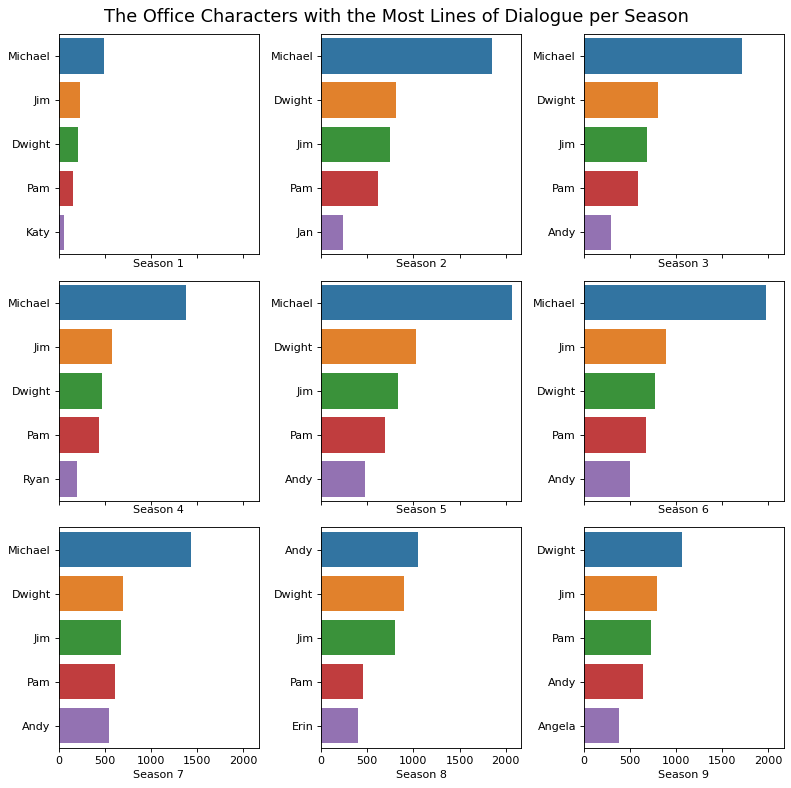

In [6]:
nrow=3
ncol=3
fig, axes = plt.subplots(nrow, ncol, figsize=(10,10),sharex = True)
fig.suptitle("The Office Characters with the Most Lines of Dialogue per Season", fontsize=16)
axes = axes.flatten()
for s in range(0, 9):
    df = lines_per_season.loc[lines_per_season['season'] == s+1,['speaker_clean','line']]
    sns.barplot(data=df, y="speaker_clean",x="line",ax=axes[s])
    axes[s].set(ylabel="",
       xlabel="Season " + str(s+1) )
plt.tight_layout()

In [7]:
series = pd.read_csv('the_office_series.csv',index_col = 0)
sns.set(rc = {'figure.figsize':(8,5)})
duration = series.drop(['About','Ratings','Votes','Viewership','Director','Writers'], axis=1).fillna(False)
duration.loc[duration.GuestStars != False, "GuestStars"] = True
duration.Date = pd.to_datetime(duration.Date)
duration.loc[duration.Date.duplicated(keep=False)]
duration.loc[duration.EpisodeTitle == 'Niagara: Part 1', "EpisodeTitle"] = "Niagara (Parts 1&2)"
duration.loc[duration.EpisodeTitle == 'The Delivery: Part 1', "EpisodeTitle"] = "The Delivery (Parts 1&2)"
duration.loc[duration.Date.duplicated(keep=False)]
duration.drop([95,108],inplace =True)
duration.reset_index(drop = True,inplace=True)

# ADD lines per char

In [8]:

data = d.copy()
data = pd.concat([duration.loc[:,["Duration","GuestStars"]],data],axis =1)

# There are part 1, part 2 episodes aired at the same day. 
# A.A.R.M, Finale actually contains two episodes!

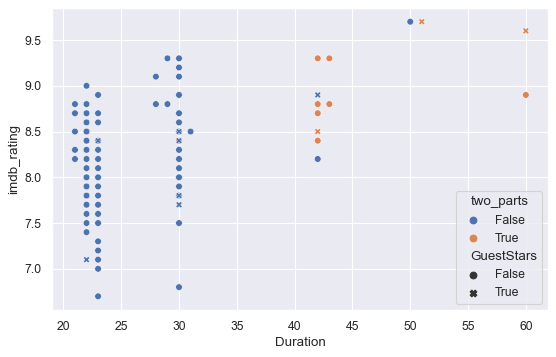

In [9]:

data["two_parts"] = data.episode_name.str.contains("Parts 1&2", case=False,regex=False)
sns.scatterplot(data=data, x = "Duration", y = "imdb_rating", hue ="two_parts", style = "GuestStars")
None

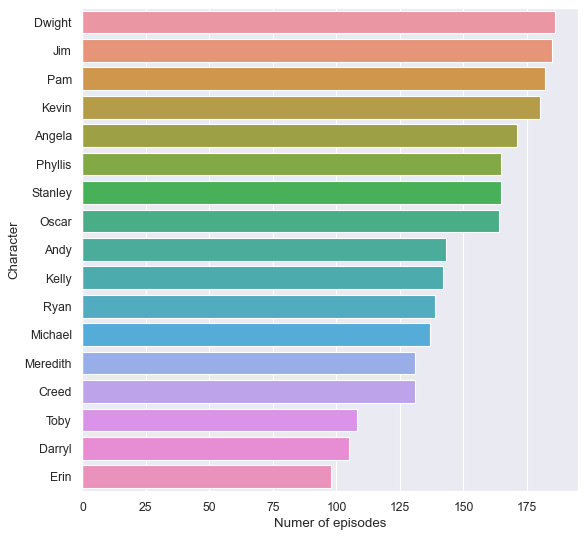

In [10]:
# feature engineering
features = data.main_chars.str.split(';').sort_index()
data['main_chars_split'] = data.main_chars.str.split(';')
char_dat = data.main_chars.str.split(';').explode().value_counts()

sns.set(rc = {'figure.figsize':(8,8)})
char_dat =char_dat.reset_index().rename(columns={'index': 'Name','main_chars': 'Counts'})
sns.barplot(y='Name',x='Counts',data=char_dat)
ax = plt.gca()
ax.set(ylabel="Character",
       xlabel="Numer of episodes")
None


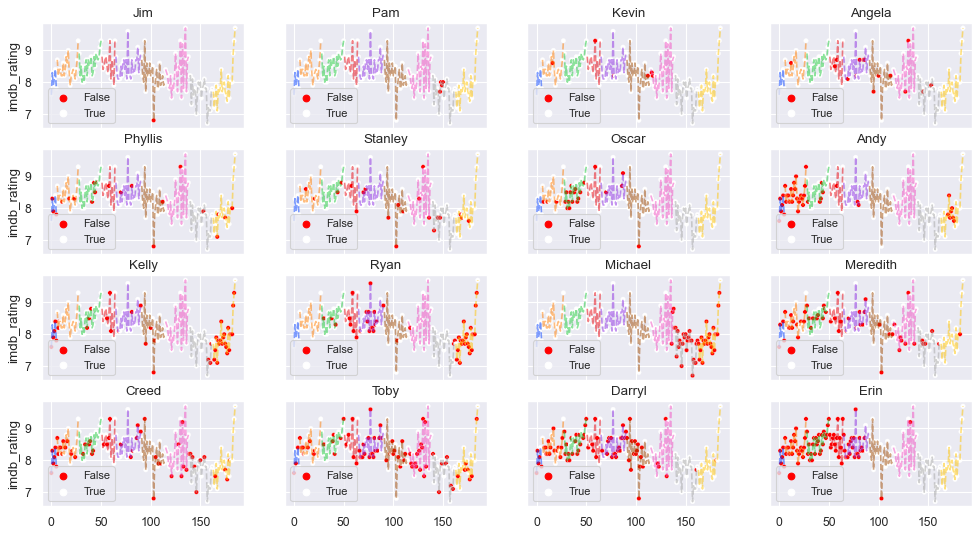

In [11]:
# We can either add a column counting total actor, it may ignore some BIG STAR
sns.set(rc = {'figure.figsize':(15,8)})
def find_name(x,*name): # *name expect a tuple here, we take only the first element!
    return name[0] in x

for name in char_dat['Name']:
    data[name] = features.apply(find_name,args=(name,))  # Use (,), or a string will be split into characters.


fig,ax = plt.subplots(4,4,sharex=True,sharey=True)
ax = ax.flatten() 

data.Dwight = data.Dwight.astype("category").cat.add_categories(['False'])
for i,name in enumerate(char_dat['Name'][1:]):
    sns.lineplot(data=data,x=data.index,y="imdb_rating",ax=ax[i],legend=False,
    palette = sns.color_palette("bright", 9),hue='season',linestyle ="--",alpha = 0.5)    
    sns.scatterplot(data=data, x=data.index, y="imdb_rating", ax=ax[i], palette=["red","white"], legend='full',hue=name, s = 16)
    sns.move_legend(ax[i], "lower left")
    ax[i].set_title(name)
    ax[i].legend(fontsize='10')



rating<=7


,Duration,GuestStars,season,episode,episode_name,director,writer,imdb_rating,total_votes,air_date,...,Andy,Kelly,Ryan,Michael,Meredith,Creed,Toby,Darryl,Erin,chars_num
103,30,False,6,14,The Banker,Jeffrey Blitz,Jason Kessler,6.8,2288,2010-01-21,...,True,False,True,True,False,False,True,False,False,8
146,23,False,8,8,Gettysburg,Jeffrey Blitz,Robert Padnick,7.0,1584,2011-11-17,...,True,True,True,False,True,False,False,True,True,14
157,23,False,8,19,Get The Girl,Rainn Wilson,Charlie Grandy,6.7,1642,2012-03-15,...,True,True,True,False,True,True,True,True,True,16


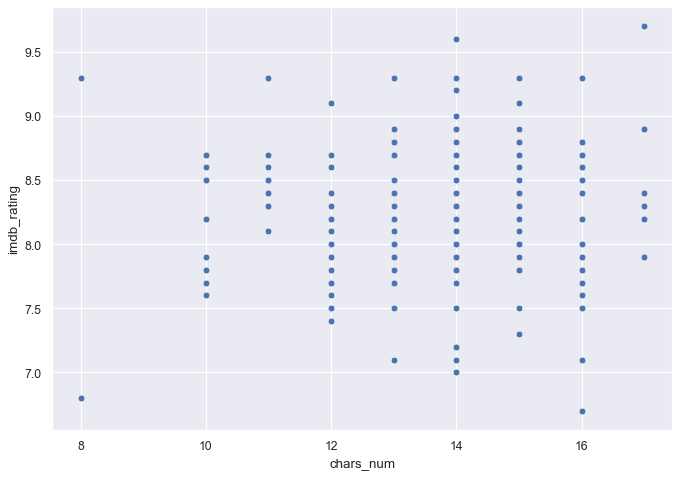

In [12]:
# Count the number of main chars.
data['chars_num'] = data.main_chars_split.apply(lambda x: len(x))
sns.set(rc={'figure.figsize':(10,7)})
sns.scatterplot(data=data, x='chars_num', y="imdb_rating")
print("rating<=7")
data.loc[(data.imdb_rating<=7)]
# The variable Season contains much information, such as Michael's leaving, The title getting old 'year',
# The crew, production etc. However, it does not give any instruction!

C:\Users\ZHONGT~1\AppData\Local\Temp/ipykernel_1640/4289962301.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  scat_plt.set_xticklabels(dir_dat_rating.index, rotation=45, horizontalalignment='right')


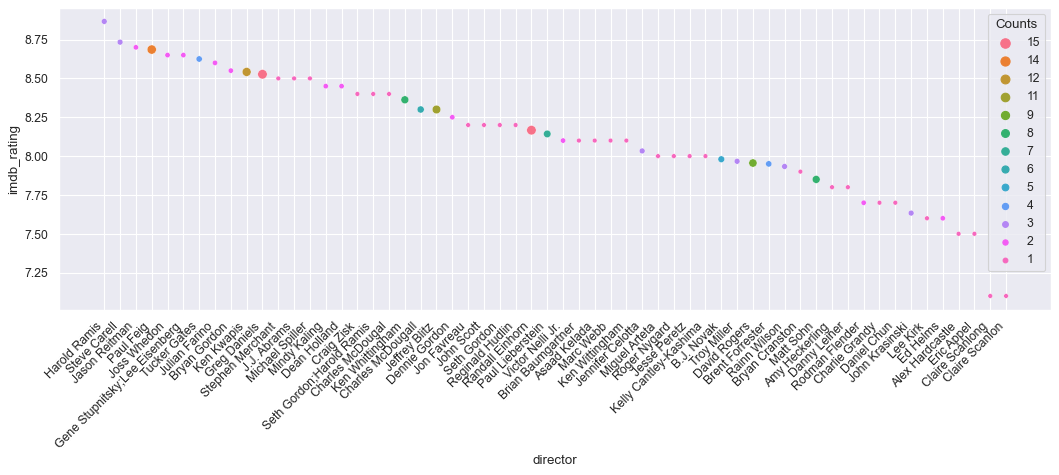

In [13]:
# there are values like A;B, B;A
data.director.loc[data.director =='Gene Stupnitsky;Lee Eisenberg']
dir_dat = data.director.explode().value_counts()
dir_dat =dir_dat.reset_index().rename(columns={'index': 'director','director': 'Counts'})

sns.set(rc = {'figure.figsize':(16,5)})
avg_rating = data[['director','imdb_rating']].groupby("director").mean()

dir_dat_rating = dir_dat.set_index("director").join(avg_rating).sort_values("imdb_rating",ascending =False)
# Change the type of 'Counts' into category.
dir_dat_rating.Counts = dir_dat_rating.Counts.astype('category')
dir_dat_rating.Counts = dir_dat_rating.Counts.cat.reorder_categories(dir_dat.Counts.unique())
# More productions, bigger size of the markers.
scat_plt = sns.scatterplot(data=dir_dat_rating, x=dir_dat_rating.index,y="imdb_rating",hue="Counts",size="Counts")
scat_plt.set_xticklabels(dir_dat_rating.index, rotation=45, horizontalalignment='right')
None


C:\Users\ZHONGT~1\AppData\Local\Temp/ipykernel_1640/545716418.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  scat_plt2.set_xticklabels(writer_dat_rating.index, rotation=45, horizontalalignment='right')


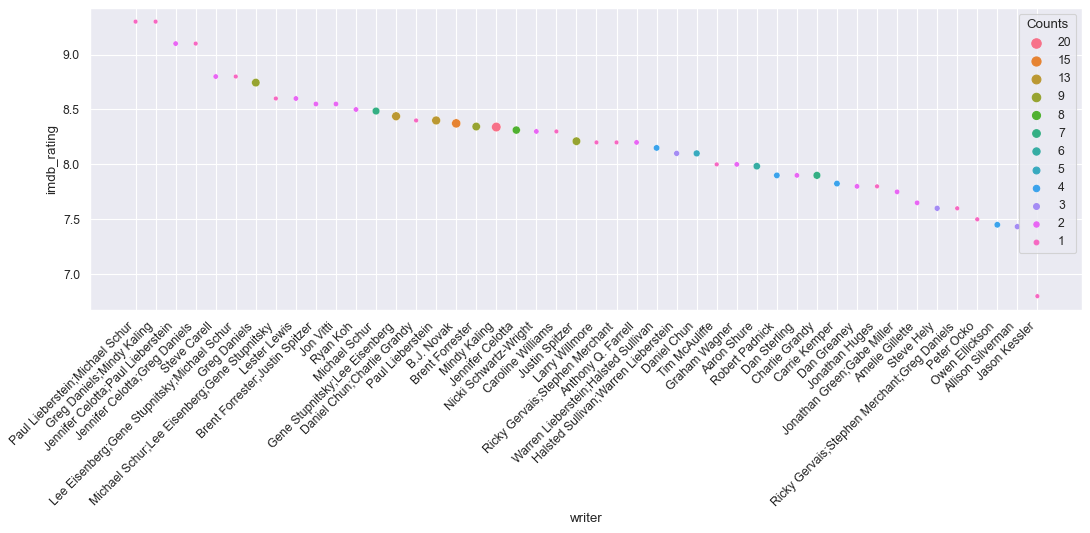

In [14]:
writer_dat = data.writer.explode().value_counts()
writer_dat = writer_dat.reset_index().rename(columns={'index': 'writer','writer': 'Counts'})

sns.set(rc = {'figure.figsize':(16,5)})
writer_avg_rating = data[['writer','imdb_rating']].groupby("writer").mean()

writer_dat_rating = writer_dat.set_index("writer").join(writer_avg_rating).sort_values("imdb_rating",ascending =False)
# Change the type of 'Counts' into category.
writer_dat_rating.Counts = writer_dat_rating.Counts.astype('category')
writer_dat_rating.Counts = writer_dat_rating.Counts.cat.reorder_categories(writer_dat.Counts.unique())
# More productions, bigger size of the markers.
scat_plt2 = sns.scatterplot(data=writer_dat_rating, x=writer_dat_rating.index,y="imdb_rating",hue="Counts",size="Counts")
scat_plt2.set_xticklabels(writer_dat_rating.index, rotation=45, horizontalalignment='right')
None

C:\Users\ZHONGT~1\AppData\Local\Temp/ipykernel_1640/602439255.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  scat_plt2.set_xticklabels(writer_dat_rating.index, rotation=45, horizontalalignment='right')


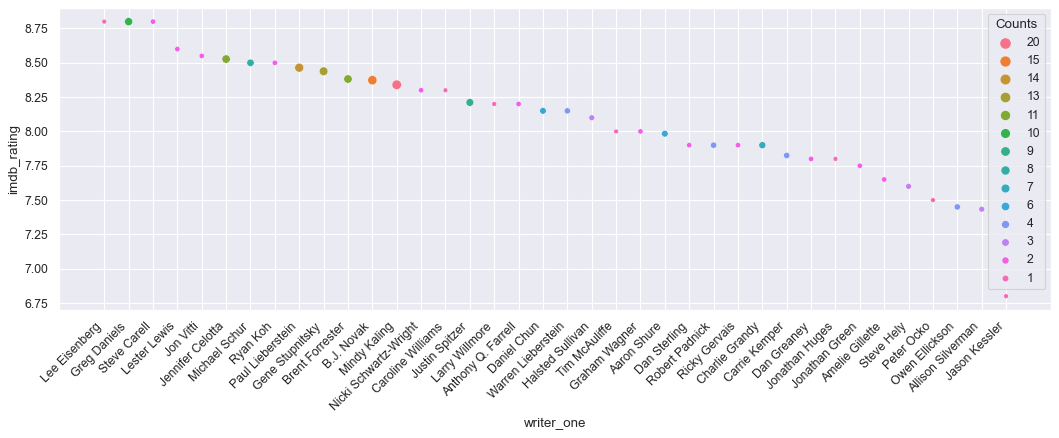

In [15]:
data["writer_one"] = data.writer.str.split(';')
data["writer_one"] = data.writer_one.apply(lambda x: x[0])
writer_dat = data.writer_one.explode().value_counts()
writer_dat =writer_dat.reset_index().rename(columns={'index': 'writer_one','writer_one': 'Counts'})

sns.set(rc = {'figure.figsize':(16,5)})
writer_avg_rating = data[['writer_one','imdb_rating']].groupby("writer_one").mean()
writer_dat_rating = writer_dat.set_index("writer_one").join(writer_avg_rating).sort_values("imdb_rating",ascending =False)
# Change the type of 'Counts' into category.
writer_dat_rating.Counts = writer_dat_rating.Counts.astype('category')
writer_dat_rating.Counts = writer_dat_rating.Counts.cat.reorder_categories(writer_dat.Counts.unique())
# More productions, bigger size of the markers.
scat_plt2 = sns.scatterplot(data=writer_dat_rating, x=writer_dat_rating.index,y="imdb_rating",hue="Counts",size="Counts")
scat_plt2.set_xticklabels(writer_dat_rating.index, rotation=45, horizontalalignment='right')
None 

In [16]:
times = 4
writer_dat["Experienced"] = writer_dat.Counts >= times 
writer_dat.loc[writer_dat.Experienced == False, "writer_one"] = "Inexperienced writer"
writer_dat.writer_one.unique()

array(['Mindy Kaling', 'B.J. Novak', 'Paul Lieberstein',
       'Gene Stupnitsky', 'Jennifer Celotta', 'Brent Forrester',
       'Greg Daniels', 'Justin Spitzer', 'Michael Schur',
       'Charlie Grandy', 'Aaron Shure', 'Daniel Chun',
       'Warren Lieberstein', 'Robert Padnick', 'Carrie Kemper',
       'Owen Ellickson', 'Inexperienced writer'], dtype=object)

In [17]:
from datetime import datetime
air_date = pd.to_datetime(data['air_date'])
data['air_date_year'] = air_date.dt.year
data['air_date_month'] = air_date.dt.month

# Concatenate the lines data with given data. Now we have how many lines each character speak in every episode

In [18]:
char_names =char_dat['Name'].values
lines_per_episode = lines_per_episode.loc[lines_per_episode.speaker_clean.apply(lambda x: x in char_names),:]
lines_per_episode.reset_index(drop=True,inplace=True)
wide_lines_per_episode =  lines_per_episode.pivot(index=['season','episode'],columns=['speaker_clean'],values=['line']).fillna(value=0)
wide_lines_per_episode = wide_lines_per_episode.droplevel([0], axis=1)
wide_lines_per_episode.reset_index(level=["season","episode"],inplace=True)
wide_lines_per_episode.rename_axis(None,axis=1,inplace=True)
wide_lines_per_episode =  wide_lines_per_episode.add_suffix("_lines")
if len(data.columns) <=40:
    data = data.merge(wide_lines_per_episode,left_on=["season","episode"],right_on =["season_lines","episode_lines"]).drop(["season_lines","episode_lines"],axis=1)

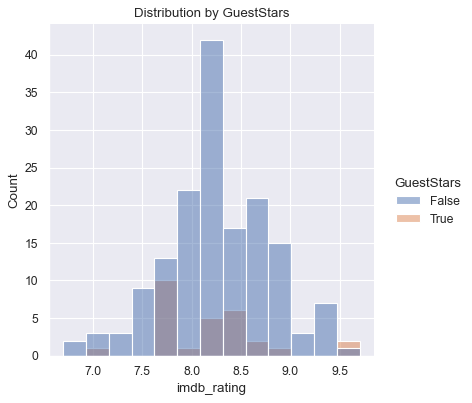

In [19]:
sns.displot(data=data,x="imdb_rating",hue="GuestStars")
plt.title("Distribution by GuestStars")
None

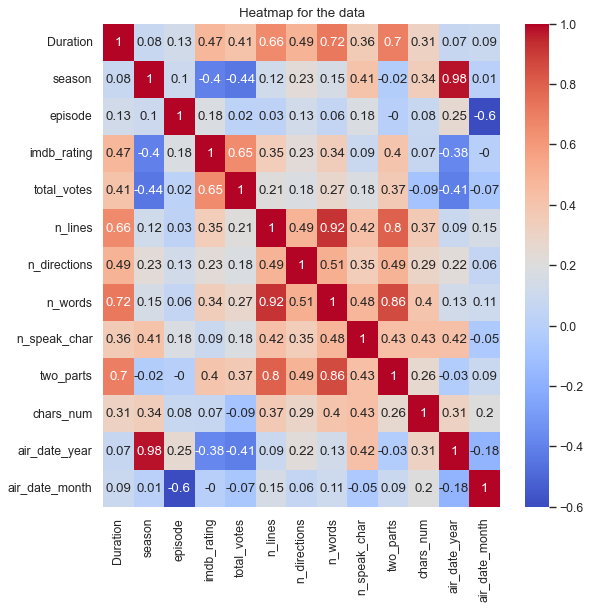

In [20]:
fig1,ax1 = plt.subplots(1,1,figsize = (8,8))
# Columns about characters.
cols_char = wide_lines_per_episode.columns[2:].tolist() + char_dat["Name"].tolist()
train_corr = data.drop(cols_char,axis=1).corr().round(2)
upper_triangle = np.triu(train_corr)  # The upper triangle will be 1 while the remain are 0.as_integer_ratio
# The cells where values take 1 while be hidden in heatmap
sns.heatmap(train_corr,annot=True,cmap='coolwarm',ax=ax1)
plt.title('Heatmap for the data')
plt.show()


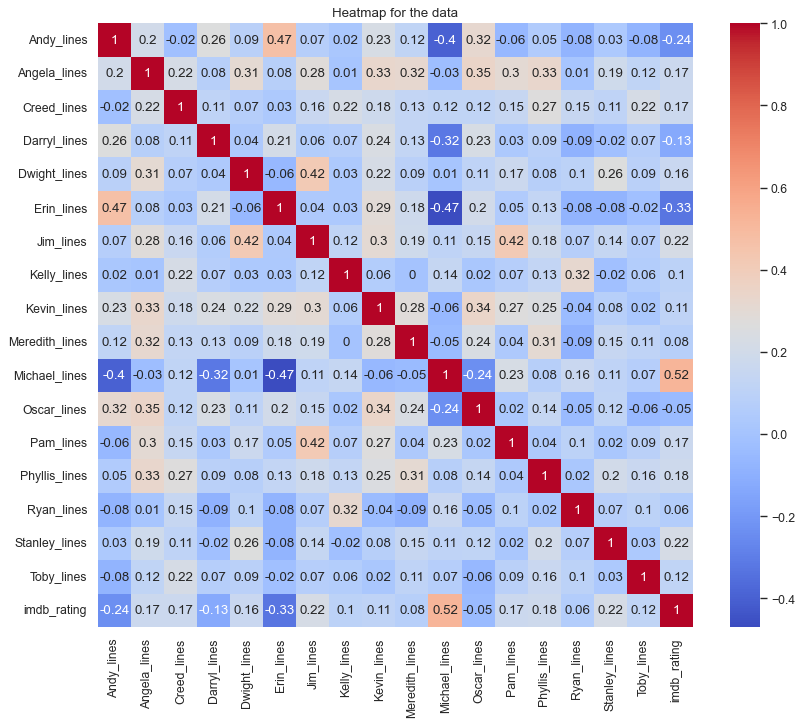

In [21]:
fig2,ax2 = plt.subplots(1,1,figsize = (12,10))
# Columns about characters.

train_corr = data.loc[:, wide_lines_per_episode.columns[2:].tolist() + ["imdb_rating"]].corr().round(2)
upper_triangle = np.triu(train_corr)  # The upper triangle will be 1 while the remain are 0.as_integer_ratio
# The cells where values take 1 while be hidden in heatmap
sns.heatmap(train_corr,annot=True,cmap='coolwarm',ax=ax2)
plt.title('Heatmap for the data')
plt.show()

# We decide to add new columns from external data - Duration, lines of each character, presence of Gueststar. Feature Engineering with given data - Character's presence: T/F, air_year (strongly correlated with season), air_month (correlated with episode), writer_one (the first writer), director_one (the first director)

In [22]:
if len(d.columns) <= 20:
    # ADD duration and GuestStars
    d = pd.concat([duration.loc[:,["Duration","GuestStars"]], d],axis =1)
    # ADD how many lines each characters speak
    d = d.merge(wide_lines_per_episode,left_on=["season","episode"],right_on =["season_lines","episode_lines"]).drop(["season_lines","episode_lines"],axis=1)
d

,Duration,GuestStars,season,episode,episode_name,director,writer,imdb_rating,total_votes,air_date,...,Kelly_lines,Kevin_lines,Meredith_lines,Michael_lines,Oscar_lines,Pam_lines,Phyllis_lines,Ryan_lines,Stanley_lines,Toby_lines
0,23,False,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,7.6,3706,2005-03-24,...,0.0,1.0,0.0,82.0,3.0,40.0,2.0,8.0,5.0,0.0
1,23,False,1,2,Diversity Day,Ken Kwapis,B.J. Novak,8.3,3566,2005-03-29,...,2.0,8.0,0.0,75.0,13.0,12.0,0.0,4.0,5.0,2.0
2,22,False,1,3,Health Care,Ken Whittingham,Paul Lieberstein,7.9,2983,2005-04-05,...,0.0,6.0,3.0,55.0,9.0,32.0,0.0,1.0,6.0,0.0
3,23,False,1,4,The Alliance,Bryan Gordon,Michael Schur,8.1,2886,2005-04-12,...,0.0,3.0,10.0,68.0,14.0,22.0,5.0,4.0,2.0,4.0
4,23,False,1,5,Basketball,Greg Daniels,Greg Daniels,8.4,3179,2005-04-19,...,0.0,1.0,0.0,105.0,2.0,14.0,4.0,8.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,22,False,9,19,Stairmageddon,Matt Sohn,Dan Sterling,8.0,1484,2013-04-11,...,0.0,5.0,2.0,0.0,7.0,9.0,5.0,0.0,18.0,14.0
182,22,False,9,20,Paper Airplane,Jesse Peretz,Halsted Sullivan;Warren Lieberstein,8.0,1482,2013-04-25,...,0.0,10.0,0.0,0.0,2.0,22.0,0.0,0.0,2.0,7.0
183,42,True,9,21,Livin' the Dream,Jeffrey Blitz,Nicki Schwartz-Wright,8.9,2041,2013-05-02,...,0.0,13.0,1.0,0.0,19.0,30.0,4.0,0.0,4.0,7.0
184,43,False,9,22,A.A.R.M (Parts 1&2),David Rogers,Brent Forrester,9.3,2860,2013-05-09,...,0.0,30.0,9.0,0.0,28.0,34.0,7.0,0.0,4.0,0.0


In [23]:
# will USE a function in pipeline called : def create_features(X,y=None,):
def create_features(X,times=6):
    X_ = X.copy()
    # Part 1&2
    X_["two_parts"] = X_.episode_name.str.contains("Parts 1&2", case=False,regex=False).astype("category")

    # Number of episodes, too many episodes can be tiring?
    episode_count = X_[["season"]].groupby("season").size().reset_index().rename(columns={0:'episode_num'})
    X_ = X_.merge(episode_count)

    # Split the air data into year, month. (correlated with season)
    air_date = pd.to_datetime(X_['air_date'])
    #X_['air_date_year'] = air_date.dt.year
    X_['air_date_month'] = air_date.dt.month.astype('category')
    X_['air_date_day'] = air_date.dt.strftime('%A').astype('category')

    # Writer 
    X_["writer_one"] = X_.writer.str.split(';')
    X_["writer_num"] = X_.writer_one.apply(lambda x: len(x))
    X_["writer_one"] = X_.writer_one.apply(lambda x: x[0])
    writer_dat_ = X_.writer_one.explode().value_counts()
    writer_dat_ =writer_dat_.reset_index().rename(columns={'index': 'writer_one','writer_one': 'Counts'})

    # Only experienced writer (times >=k), otherwise = "Unexperienced writer"
    writer_dat_.loc[(writer_dat_.Counts >= times)  == False,"writer_one"] = "Inexperienced writer"
    experienced_writer = writer_dat_["writer_one"].unique()
    X_["writer_one"] = X_["writer_one"].apply(lambda x: x if x in experienced_writer else "Inexperienced").astype('category')
    
    # Samely, create features for director!
    X_["director_one"] = X_.director.str.split(';')
    X_["director_num"] = X_.director_one.apply(lambda x: len(x))
    X_["director_one"] = X_.director_one.apply(lambda x: x[0])
    director_dat_ = X_.director_one.explode().value_counts()
    director_dat_ = director_dat_.reset_index().rename(columns={'index': 'director_one','director_one': 'Counts'})

    # Only experienced director (times >=k), otherwise = "Unexperienced director"
    director_dat_.loc[(director_dat_.Counts >= times)  == False,"director_one"] = "Inexperienced director"
    experienced_director = director_dat_["director_one"].unique()
    X_["director_one"] = X_["director_one"].apply(lambda x: x if x in experienced_director else "Inexperienced").astype('category')
    
    # Create char_num, variables named after character's name.
    features_ = X_.main_chars.str.split(';').sort_index()
    X_['main_chars_split'] = X_.main_chars.str.split(';')
    """
    char_dat_ = X_.main_chars.str.split(';').explode().value_counts()
    char_dat_ =char_dat_.reset_index().rename(columns={'index': 'Name','main_chars': 'Counts'})
    X_['char_num'] = X_['main_chars_split'].apply(lambda x: len(x))
    def find_name(x,*name): # *name expect a tuple here, we take only the first element!
        return name[0] in x

    for name in char_dat_['Name']:
        X_[name] = features_.apply(find_name,args=(name,))  # Use (,), or a string will be split into characters.
        X_[name] = X_[name].astype('category') """

    # Drop unwanted variable!
    X_.drop(['season','episode','episode_name',
    'director','writer',
    'air_date', 'air_date_month',
    'main_chars','main_chars_split',
    'n_words'],axis = 1,inplace=True)
    return X_
    

In [24]:
crt = FunctionTransformer(create_features)
y = d.imdb_rating
X = d.drop(['imdb_rating','total_votes'],axis=1)
X = crt.fit_transform(X)
weights_by_votes = d.total_votes
X.GuestStars = X.GuestStars.astype("category")
X.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 186 entries, 0 to 185
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Duration        186 non-null    int64   
 1   GuestStars      186 non-null    category
 2   n_lines         186 non-null    int64   
 3   n_directions    186 non-null    int64   
 4   n_speak_char    186 non-null    int64   
 5   Andy_lines      186 non-null    float64 
 6   Angela_lines    186 non-null    float64 
 7   Creed_lines     186 non-null    float64 
 8   Darryl_lines    186 non-null    float64 
 9   Dwight_lines    186 non-null    float64 
 10  Erin_lines      186 non-null    float64 
 11  Jim_lines       186 non-null    float64 
 12  Kelly_lines     186 non-null    float64 
 13  Kevin_lines     186 non-null    float64 
 14  Meredith_lines  186 non-null    float64 
 15  Michael_lines   186 non-null    float64 
 16  Oscar_lines     186 non-null    float64 
 17  Pam_lines       

In [25]:
X.loc[[185],"Andy_lines":]

,Andy_lines,Angela_lines,Creed_lines,Darryl_lines,Dwight_lines,Erin_lines,Jim_lines,Kelly_lines,Kevin_lines,Meredith_lines,...,Ryan_lines,Stanley_lines,Toby_lines,two_parts,episode_num,air_date_day,writer_one,writer_num,director_one,director_num
185,31.0,23.0,8.0,19.0,76.0,11.0,73.0,12.0,31.0,15.0,...,15.0,8.0,13.0,True,23,Thursday,Greg Daniels,1,Ken Kwapis,1


In [26]:
X.loc[[185],:"Andy_lines"]

,Duration,GuestStars,n_lines,n_directions,n_speak_char,Andy_lines
185,51,True,522,107,54,31.0


In [27]:
print(X.columns)

Index(['Duration', 'GuestStars', 'n_lines', 'n_directions', 'n_speak_char',
       'Andy_lines', 'Angela_lines', 'Creed_lines', 'Darryl_lines',
       'Dwight_lines', 'Erin_lines', 'Jim_lines', 'Kelly_lines', 'Kevin_lines',
       'Meredith_lines', 'Michael_lines', 'Oscar_lines', 'Pam_lines',
       'Phyllis_lines', 'Ryan_lines', 'Stanley_lines', 'Toby_lines',
       'two_parts', 'episode_num', 'air_date_day', 'writer_one', 'writer_num',
       'director_one', 'director_num'],
      dtype='object')


In [28]:
def model_fit(m, X, y, plot = False):
    """Returns the root mean squared error of a fitted model based on provided X and y values.
    
    Args:
        m: sklearn model object
        X: model matrix to use for prediction
        y: outcome vector to use to calculating rmse and residuals
        plot: boolean value, should fit plots be shown 
    """
    
    y_hat = m.predict(X)
    rmse = np.sqrt(mean_squared_error(y, y_hat))
    
    res = pd.DataFrame(
        data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat}
    )
    
    if plot:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(121)
        sns.lineplot(x='y', y='y_hat', color="grey", data =  pd.DataFrame(data={'y': [min(y),max(y)], 'y_hat': [min(y),max(y)]}))
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Fit plot")
        
        plt.subplot(122)
        sns.scatterplot(x='y', y='resid', data=res).set_title("Residual plot")
        plt.hlines(y=0, xmin=np.min(y), xmax=np.max(y), linestyles='dashed', alpha=0.3, colors="black")
        
        plt.subplots_adjust(left=0.0)
        
        plt.suptitle("Model rmse = " + str(round(rmse, 4)), fontsize=16)
        plt.show()
    
    return rmse

In [29]:
from sklearn.compose import make_column_selector as selector
one_hot = OneHotEncoder(handle_unknown="ignore")
preprocessor = ColumnTransformer(transformers=
                            [('One hot',one_hot, selector(dtype_include="category"))],
                            remainder='passthrough') 

In [30]:
#possible_depth = np.arange(2,10)
alpha = np.linspace(0,0.01,1000)
model = DecisionTreeRegressor(max_depth=10)
pipe = make_pipeline(
    preprocessor,
    model)
gs = GridSearchCV(pipe,
    param_grid={#"decisiontreeregressor__max_depth": possible_depth,
    #"decisiontreeregressor__splitter":["random","best"],
    "decisiontreeregressor__ccp_alpha":alpha,
    "decisiontreeregressor__criterion":['squared_error', 'friedman_mse']},
    cv=KFold(5,shuffle=True, random_state=1234),
    scoring="neg_root_mean_squared_error",
    n_jobs=-1)
gs.fit(X,y,decisiontreeregressor__sample_weight = weights_by_votes)
None

In [31]:
# Cite week 5 workshop


cv_res = pd.DataFrame(
    data = gs.cv_results_
).filter(
    # Extract the split#_test_score and mean_test_score columns
    regex = '(split[0-9]+|mean)_test_score|param_'
)
cv_res.update(
    # Convert negative rmses to positive
    -1 * cv_res.filter(regex = '_test_score')
)


cv_res.rename(columns={'param_decisiontreeregressor__criterion': 'criterion',
'param_decisiontreeregressor__ccp_alpha': 'alpha'},inplace=True)
""" cv_res.rename(columns={'param_decisiontreeregressor__criterion': 'criterion',
'param_decisiontreeregressor__max_depth': 'depth'},inplace=True) """
cv_res

,alpha,criterion,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score
0,0.0,squared_error,0.460306,0.656765,0.564984,0.616986,0.517461,0.563300
1,0.0,friedman_mse,0.489401,0.618369,0.554256,0.672125,0.502355,0.567301
2,0.00001,squared_error,0.462588,0.577720,0.559637,0.664192,0.532358,0.559299
3,0.00001,friedman_mse,0.464858,0.648607,0.548449,0.704135,0.558599,0.584930
4,0.00002,squared_error,0.471602,0.567547,0.557145,0.659747,0.489764,0.549161
...,...,...,...,...,...,...,...,...
1995,0.00998,friedman_mse,0.475318,0.615613,0.522182,0.539975,0.375001,0.505618
1996,0.00999,squared_error,0.475318,0.615613,0.522182,0.539975,0.375001,0.505618
1997,0.00999,friedman_mse,0.475318,0.615613,0.522182,0.539975,0.375001,0.505618
1998,0.01,squared_error,0.475318,0.615613,0.528175,0.539975,0.375001,0.506816


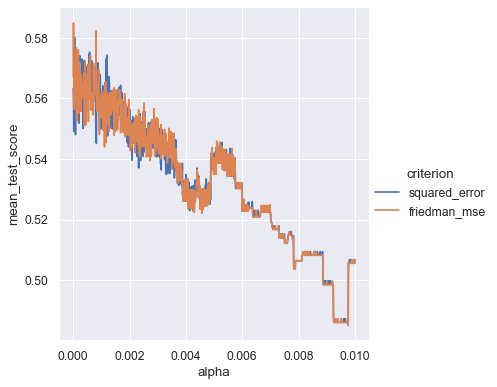

In [32]:
""" sns.relplot(x='alpha', y='mean_test_score', data=cv_res,hue='criterion', col="param_decisiontreeregressor__splitter",kind="line")
plt.show() """
sns.relplot(x='alpha', y='mean_test_score', data=cv_res,hue='criterion',kind="line")
plt.show()

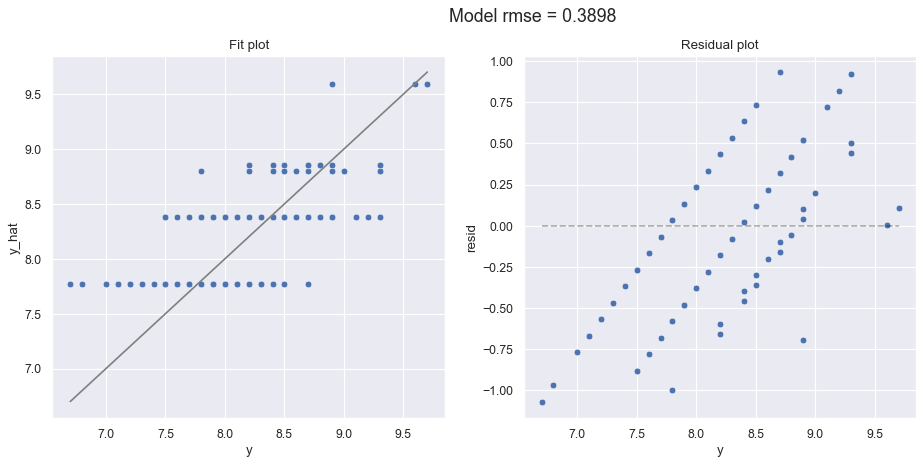

0.38976785010954496

In [33]:
def model_fit(m, X, y, plot = False):
    """Returns the root mean squared error of a fitted model based on provided X and y values.
    
    Args:
        m: sklearn model object
        X: model matrix to use for prediction
        y: outcome vector to use to calculating rmse and residuals
        plot: boolean value, should fit plots be shown 
    """
    
    y_hat = m.predict(X)
    rmse = np.sqrt(mean_squared_error(y, y_hat))
    
    res = pd.DataFrame(
        data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat}
    )
    
    if plot:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(121)
        sns.lineplot(x='y', y='y_hat', color="grey", data =  pd.DataFrame(data={'y': [min(y),max(y)], 'y_hat': [min(y),max(y)]}))
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Fit plot")
        
        plt.subplot(122)
        sns.scatterplot(x='y', y='resid', data=res).set_title("Residual plot")
        plt.hlines(y=0, xmin=np.min(y), xmax=np.max(y), linestyles='dashed', alpha=0.3, colors="black")
        
        plt.subplots_adjust(left=0.0)
        
        plt.suptitle("Model rmse = " + str(round(rmse, 4)), fontsize=16)
        plt.show()
    
    return rmse
model_fit(gs.best_estimator_, X, y, plot=True)

# Result Visualization: Plot the best tree and Scatterplot using TSNE

In [34]:
resid = y - gs.best_estimator_.predict(X) 
check_dat = d.copy()
check_dat['resid'] = resid
check_dat['pred'] = gs.best_estimator_.predict(X) 

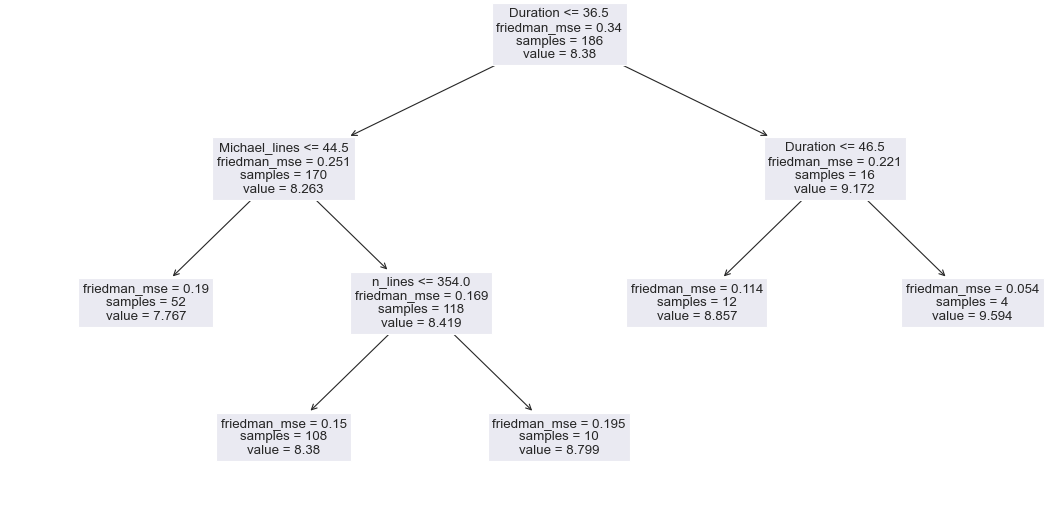

In [35]:
col_trans = gs.best_estimator_.named_steps['columntransformer']

features_names= col_trans.get_feature_names_out()               

cat_feature_names = col_trans.named_transformers_["One hot"].get_feature_names_out()    # This get all the categorical features' names.
for i in range(len(cat_feature_names)):                       
    features_names[i] = cat_feature_names[i]
for i in range(len(features_names)):
    features_names[i] = re.sub("remainder__", 
        "",
        features_names[i])    
fig = plt.figure(figsize=(16,8))
fig = plot_tree(gs.best_estimator_.named_steps['decisiontreeregressor'],feature_names= features_names,fontsize=12)
None 

In [36]:
# It is strange to have "air_data_month" as a predictor
d.loc[(d.Duration> 40.7)]

,Duration,GuestStars,season,episode,episode_name,director,writer,imdb_rating,total_votes,air_date,...,Kelly_lines,Kevin_lines,Meredith_lines,Michael_lines,Oscar_lines,Pam_lines,Phyllis_lines,Ryan_lines,Stanley_lines,Toby_lines
37,42,False,3,10,A Benihana Christmas (Parts 1&2),Harold Ramis,Jennifer Celotta,8.7,2541,2006-12-14,...,5.0,14.0,3.0,109.0,1.0,57.0,12.0,8.0,3.0,8.0
50,42,False,3,24,The Job (Parts 1&2),Ken Kwapis,Paul Lieberstein;Michael Schur,9.3,3010,2007-05-17,...,3.0,17.0,6.0,114.0,10.0,42.0,4.0,4.0,7.0,0.0
51,42,False,4,1,Fun Run (Parts 1&2),Greg Daniels,Greg Daniels,8.8,2826,2007-09-27,...,6.0,17.0,18.0,130.0,9.0,81.0,4.0,7.0,9.0,9.0
52,42,False,4,3,Dunder Mifflin Infinity (Parts 1&2),Craig Zisk,Michael Schur,8.4,2248,2007-10-04,...,19.0,13.0,0.0,139.0,3.0,50.0,13.0,78.0,5.0,18.0
53,42,True,4,5,Launch Party (Parts 1&2),Ken Whittingham,Jennifer Celotta,8.5,2173,2007-10-11,...,8.0,14.0,12.0,146.0,8.0,24.0,8.0,6.0,7.0,0.0
54,42,False,4,7,Money (Parts 1&2),Paul Lieberstein,Paul Lieberstein,8.7,2341,2007-10-18,...,12.0,9.0,1.0,136.0,25.0,50.0,2.0,21.0,7.0,2.0
64,42,False,4,18,"Goodbye, Toby (Parts 1&2)",Paul Feig,Jennifer Celotta;Paul Lieberstein,9.3,3010,2008-05-15,...,4.0,23.0,4.0,159.0,1.0,42.0,16.0,5.0,1.0,37.0
65,43,False,5,1,Weight Loss (Parts 1&2),Paul Feig,Gene Stupnitsky;Lee Eisenberg,8.8,2501,2008-09-25,...,12.0,14.0,4.0,114.0,18.0,37.0,16.0,17.0,8.0,1.0
77,60,True,5,14,Stress Relief (Parts 1&2),Jeffrey Blitz,Paul Lieberstein,9.6,5948,2009-02-01,...,3.0,8.0,3.0,120.0,10.0,31.0,11.0,0.0,28.0,0.0
125,60,False,7,11,Classy Christmas (Parts 1&2),Rainn Wilson,Mindy Kaling,8.9,2138,2010-12-09,...,14.0,14.0,10.0,130.0,12.0,69.0,13.0,11.0,5.0,25.0


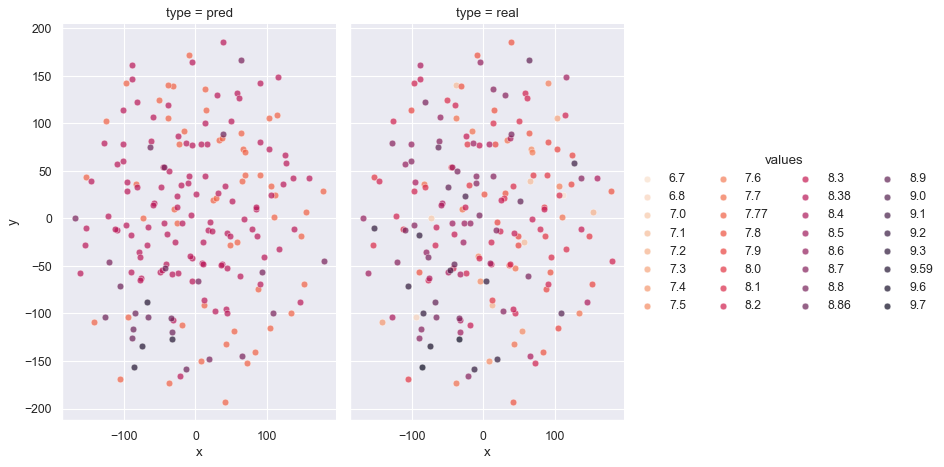

In [106]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
visualization_preprocessor = ColumnTransformer(transformers=[('One hot',one_hot, selector(dtype_include="category")),
                            ('Scaler',StandardScaler(), selector(dtype_include="number"))]) 
tsne = TSNE(n_components=3, perplexity = 10, random_state= 23 , init = "random",learning_rate=200) #Initialization using PCA
data_tsne = tsne.fit_transform(visualization_preprocessor.fit_transform(X))
df_tsne = pd.DataFrame(data_tsne, columns=['x', 'y','z'])
df_tsne = pd.concat([df_tsne,df_tsne],axis = 0)
df_tsne['values'] = np.concatenate([np.around(gs.best_estimator_.predict(X),2),y])
df_tsne['type'] = ['pred' for i in range(len(d))] + ['real' for i in range(len(d))]


#-v-v-v-v- Plot your clustered data for both x and y as a scatter plot. -v-v-v-v
#-v-v-v-v- Write your code here -v-v-v-v
#set_xlim((df_tsne.min()['x']-1,df_tsne.max()['x']+1))
num_values = len(df_tsne['values'].unique())

g = sns.FacetGrid(df_tsne, hue= "values", col = "type",palette = sns.color_palette("rocket_r",num_values),
 height= 6, aspect=0.7)
g.map(sns.scatterplot, "x", "y", alpha=.7)
g.add_legend(ncol = 4)





___________________________________________________________________

## 1. Introduction

*This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a client). If you use any additional data sources, you should introduce them here and discuss why they were included.*

*Briefly outline the approaches being used and the conclusions that you are able to draw.*

## 2. Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling. Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. Think carefully about whether each plot needs to be included in your final draft - your report should include figures but they should be as focused and impactful as possible.*

*Additionally, this section should also implement and describe any preprocessing / feature engineering of the data. Specifically, this should be any code that you use to generate new columns in the data frame `d`. All of this processing is explicitly meant to occur before we split the data in to training and testing subsets. Processing that will be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

*All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.*

## 3. Model Fitting and Tuning

*In this section you should detail your choice of model and describe the process used to refine and fit that model. You are strongly encouraged to explore many different modeling methods (e.g. linear regression, regression trees, lasso, etc.) but you should not include a detailed narrative of all of these attempts. At most this section should mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using and your process for tuning and validatin it.*

*For example if you considered a linear regression model, a classification tree, and a lasso model and ultimately settled on the linear regression approach then you should mention that other two approaches were tried but do not include any of the code or any in depth discussion of these models beyond why they were rejected. This section should then detail is the development of the linear regression model in terms of features used, interactions considered, and any additional tuning and validation which ultimately led to your final model.* 

*This section should also include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.*

## 4. Discussion & Conclusions


*In this section you should provide a general overview of your final model, its performance, and reliability. You should discuss what the implications of your model are in terms of the included features, predictive performance, and anything else you think is relevant.*

*This should be written with a target audience of a NBC Universal executive who is with the show and  university level mathematics but not necessarily someone who has taken a postgraduate statistical modeling course. Your goal should be to convince this audience that your model is both accurate and useful.*

*Finally, you should include concrete recommendations on what NBC Universal should do to make their reunion episode a popular as possible.*

*Keep in mind that a negative result, i.e. a model that does not work well predictively, that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explinations / justifications.*